In [0]:
a = []
while 1:
  a.append('1')

In [2]:
# import Library Files 

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import glob
import os

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, GlobalAveragePooling2D
from tensorflow.keras.layers import LeakyReLU, Input, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard

from datetime import datetime
from IPython import display
import math
import cv2



KeyboardInterrupt: ignored

In [3]:
# To access the data from google drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Read Data from the file
I will use only 2 folder images data there are 3988 images in that

In [4]:
# Read data from drive
# I used only 2 floders for train the models
# 1 folder for test data
img_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0000/*.png')
img_paths.extend(glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0001/*.png'))

sketch_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0000/*.png')
sketch_paths.extend(glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0001/*.png'))

test_img_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/src/0002/*.png')
test_sketch_paths = glob.glob('/content/gdrive/My Drive/Case Study 2/Data/sketch/0002/*.png')

img_paths.sort()
sketch_paths.sort()

test_img_paths.sort()
test_sketch_paths.sort()

img_paths = np.array(img_paths)
sketch_paths = np.array(sketch_paths)

test_img_paths = np.array(test_img_paths)
test_sketch_paths = np.array(test_sketch_paths)

print (len(img_paths))
print (len(sketch_paths))

print (len(test_img_paths))
print (len(test_sketch_paths))

global TOTAL_IMAGES
TOTAL_IMAGES = len(img_paths)

TOTAL_TEST_IMAGES = len(test_img_paths)

3988
3988
1956
1956


In [0]:
s1 = os.listdir(path='/content/gdrive/My Drive/Case Study 2/Data/src/0001/')
s2 = os.listdir(path='/content/gdrive/My Drive/Case Study 2/Data/sketch/0001/')
print (len(s1))
print (len(s2))
print (set(s1) - set(s2))
print (set(s2) - set(s1))

ls = list(set(s1) - set(s2))
for f in ls:
 os.remove("/content/gdrive/My Drive/Image Colorization/Data/src/0001/"+f)
ls = list(set(s2) - set(s1))
for f in ls:
  os.remove("/content/gdrive/My Drive/Image Colorization/Data/src/0001/"+f)


2002
2002
set()
set()


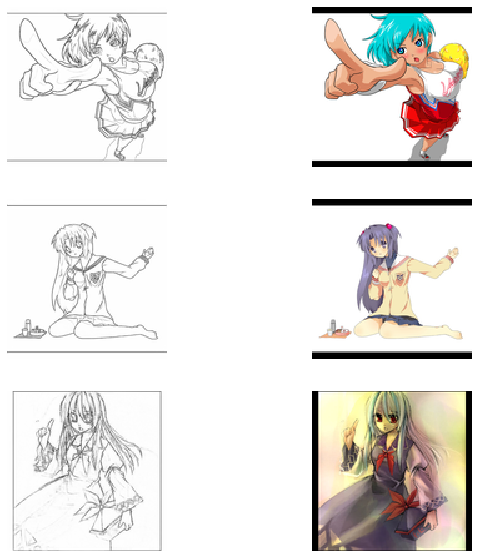

In [0]:
# To check the read files are correct or not?
# Sample color and sketch images

import matplotlib.image as mpimg
image1 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/sketch/0002/247002.png').convert('RGB')
image2 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/0002/247002.png')

image3 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/sketch/0001/174001.png').convert('RGB')
image4 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/0001/174001.png')

image5 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/sketch/0000/41000.png').convert('RGB')
image6 = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/0000/41000.png')


plt.figure(figsize=(10,10))
plt.title("Skech Image and color Image")
plt.subplot(3, 2, 1)
plt.axis('off')
plt.imshow(image1)


plt.subplot(3, 2, 2)
plt.axis('off')
plt.imshow(image2)

plt.subplot(3, 2, 3)
plt.axis('off')
plt.imshow(image3)

plt.subplot(3, 2, 4)
plt.axis('off')
plt.imshow(image4)

plt.subplot(3, 2, 5)
plt.axis('off')
plt.imshow(image5)

plt.subplot(3, 2, 6)
plt.axis('off')
plt.imshow(image6)



GAN Network 
Generator with swish residual connection 


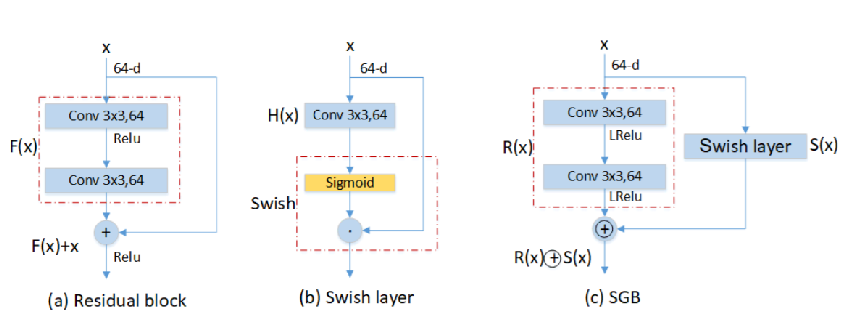

In [0]:
"""
Displaying the complete U-Net architechture.
"""
gan = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/Capture.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
def convolution(inp, n_filters, filter_size = 3, strides = 1, alpha = 0.2):

  """
  Function for do convolution operation
  """
  inp = Conv2D(n_filters, filter_size, strides, padding = 'same', kernel_initializer= tf.keras.initializers.truncated_normal(stddev=0.02) ) (inp)

  inp = LeakyReLU(alpha = alpha)(inp)

  return inp

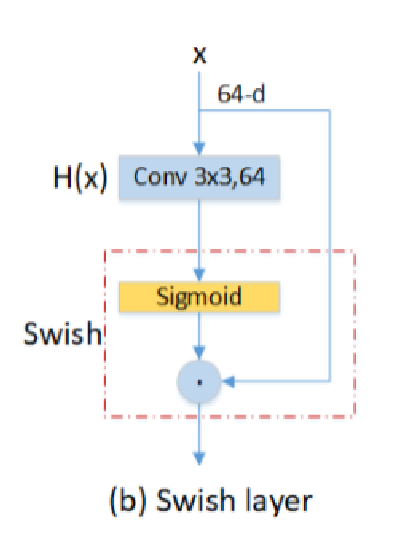

In [26]:

"""
Displaying the complete GAN architechture.
"""
gan = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/SwishNet.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Swish Layer
def SwishMod(inp, filter_size = 3, stride = 2, padding ='same', batchNormalize = True, alpha = 0.2):

  """
    Function for swish layer operation
    Take input image perform conv operatin perform dot on input and conv output(multiply operation on both) return result element wise multimplication
    Filter are the channels in input images
    Here input and output are the same shape if input (64, 64, 3) output also (64, 64,3) 
  """
  filters = list(inp.get_shape())[-1]
  conv = Conv2D(filters, filter_size, padding = 'same', kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(inp)
  conv = sigmoid(conv)

  swished = tf.keras.layers.multiply([inp, conv])
  #print (swished.shape)

  return swished


In [0]:
def convBlock(inp, n_filters, filter_size = 3, padding = 'same', batchNormalize = True, con1X1 = True, cat = None, dropout = False, alpha = 0.2):

  '''
  Function for convolution block 
  It take input and perform convolution operation and generate output for next layer
  '''
  if con1X1:
    inp = convolution(inp, n_filters, filter_size )#,  batchNormalize=batchNormalize)

  conv1 = convolution(inp, n_filters, filter_size)
  conv2 = convolution(conv1, n_filters, filter_size)

  if cat is None:

    max1 = MaxPooling2D(pool_size = 2, strides = 2) (conv2)
    swish = MaxPooling2D(pool_size = 2, strides = 2) (inp)
    swish = SwishMod(swish)
    concat = tf.keras.layers.concatenate([max1, swish])
    

  else:

    sgb_op = Conv2DTranspose(n_filters, (2, 2), strides = (2, 2), padding = 'same', kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(conv2)
    sgb_op = BatchNormalization()(sgb_op)

    if dropout:
      sgb_op = Dropout(rate = 0.5) (sgb_op)
    sgb_op = LeakyReLU(alpha = alpha) (sgb_op)

    swish = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02)) (conv2)
    swish = BatchNormalization()(swish)
    if dropout:
      swish = Dropout(rate = 0.5) (swish)
    swish = LeakyReLU(alpha = 0.2)(swish)
    
    swish = SwishMod(swish)
    concat = tf.keras.layers.concatenate([sgb_op, swish, cat])

  return concat, conv2

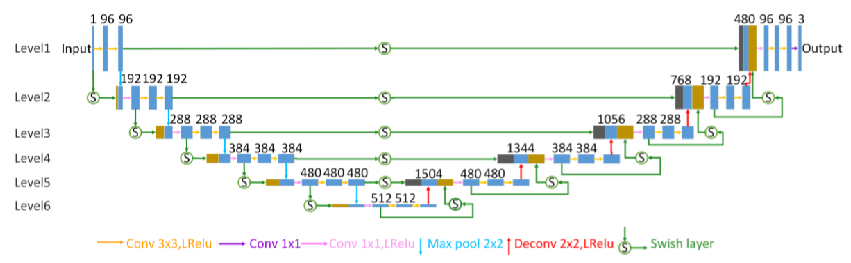

In [29]:
"""
Displaying the U-Net Structure architechture.
"""
gan = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/U-NetCapture.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Define Generator Which is responsible for generating Fake data 

def Generator(inp_shape = (128, 128, 3)):
    '''
        Function for creating generator model
        It is generate the color image from the given input black and white sketch
        It is same swish gated U-Net structure.
    '''

    n_filters = 64
    dropout = 0.5

    inp = Input(inp_shape)

    print ("Encoder")
    inputs, conv1 = convBlock(inp, n_filters, batchNormalize = False, con1X1 = False)
    inputs, conv2 = convBlock(inputs, n_filters * 2)
    inputs, conv3 = convBlock(inputs, n_filters * 3)
    inputs, conv4 = convBlock(inputs, n_filters * 4)
    inputs, conv5 = convBlock(inputs, n_filters * 5)
    inputs, conv6 = convBlock(inputs, n_filters * 6)

    conv1 = SwishMod(conv1)
    conv2 = SwishMod(conv2)
    conv3 = SwishMod(conv3)
    conv4 = SwishMod(conv4)
    conv5 = SwishMod(conv5)
    conv6 = SwishMod(conv6)
    print ("Decoder")
    inputs, _ = convBlock(inputs, n_filters * 6, cat = conv6, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 5, cat = conv5, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 4, cat = conv4, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 3, cat = conv3, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 2, cat = conv2, dropout = 0.5)
    inputs, _ = convBlock(inputs, n_filters * 1, cat = conv1)

    out = Conv2D(3, 3, activation='tanh', padding = 'same' ) (inputs)

    model = Model(inputs=inp, outputs= out)

    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    
    #model.compile(loss='binary_crossentropy', optimizer= opt)
    
    return model


In [31]:
model = Generator(inp_shape = (128, 128, 3))
model.summary()  

Encoder
Decoder
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 128, 128, 64) 1792        input_17[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_57 (LeakyReLU)      (None, 128, 128, 64) 0           conv2d_71[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 64, 64, 3)    0           input_17[0][0]                   
___________________________________________________________________________

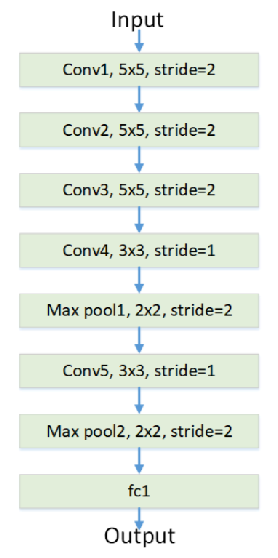

In [0]:
"""
Architecture of Discriminator.
"""
gan = Image.open('/content/gdrive/My Drive/Case Study 2/Data/src/DiscArchitecture.PNG').convert('RGB')

plt.figure(figsize=(15, 10))
plt.imshow(gan)
plt.axis('off')
plt.show()

In [0]:
# Discriminator Model

def Discriminator(input_shape = (128, 128, 3), target_shape = (128, 128, 3)):
  '''
    Create a discriminator model
    It take 2 inputs 
  '''

  n_filters = 64
  learning_rate = 0.0002

  inp1 = Input(input_shape)
  inp2 = Input(target_shape)

  inp = concatenate([inp1, inp2])

  conv = convolution(inp, n_filters, 5, strides = 2)
  conv = convolution(conv, n_filters *2, 5, strides = 2)
  conv = convolution(conv, n_filters *4, 5, strides = 1)

  maxPool = MaxPooling2D(pool_size= (2, 2))(conv)

  conv = convolution(maxPool, n_filters*8, 3, strides = 1)

  maxPool = MaxPool2D( pool_size=(2, 2))(conv)
  conv = Conv2D(1, 2, strides = 1, activation = 'sigmoid', padding = 'valid')(maxPool)

  out = GlobalAveragePooling2D()(conv)

  model = Model(inputs = [inp1, inp2], outputs = out)
  opt = Adam(lr = 0.0002, beta_1 = 0.5)

  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model



In [35]:
model = Discriminator()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
concatenate_32 (Concatenate)    (None, 128, 128, 6)  0           input_20[0][0]                   
                                                                 input_21[0][0]                   
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 64, 64, 64)   9664        concatenate_32[0][0]      

In [0]:
"""
Download VGG19 model for extracting basic features like edges, shapes
"""
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19

vgg = VGG19(weights = 'imagenet', include_top = False)

In [37]:
from tensorflow.keras.layers import ReLU
# Take different layers layer model of vgg19
vgg_net1_1 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block1_conv2').output))
vgg_net1_2 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block2_conv2').output))
vgg_net1_3 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block3_conv2').output))
vgg_net1_4 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block4_conv2').output))
vgg_net1_5 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block5_conv2').output))

vgg_net2_1 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block1_conv2').output))
vgg_net2_2 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block2_conv2').output))
vgg_net2_3 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block3_conv2').output))
vgg_net2_4 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block4_conv2').output))
vgg_net2_5 = Model(inputs = vgg.input, outputs =ReLU()(vgg.get_layer('block5_conv2').output))

vgg_net2_5.summary()


Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

In [0]:
# Custom Loss Function
# https://heartbeat.fritz.ai/how-to-create-a-custom-loss-function-in-keras-637bd312e9ab

def layer1_loss(y, g):
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  return layer_loss_value

def layer2_loss(y, g):
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  return layer_loss_value

def layer3_loss(y, g):
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  return layer_loss_value

def layer4_loss(y, g):
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  return layer_loss_value

def layer5_loss(y, g):
  def layer_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  return layer_loss_value 

def pixelLevel_loss(y, g):
  def pixel_loss_value(y_true, y_pred):
    return K.mean( K.abs( y - g ) )

  return pixel_loss_value

# Loss functtion
#def ssim_loss(y_true, y_pred):
#  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


In [0]:
def def_GAN(generator, discriminator, vgg_net1_1, vgg_net1_2, vgg_net1_3, vgg_net1_4, vgg_net1_5, input_shape = (128, 128, 3)):#, vgg_net2_1, vgg_net2_2, vgg_net2_3, vgg_net2_4, vgg_net2_5, 
  

  # To freez the dicrimator weights
  discriminator.trainable = False

  sketchImg = Input(input_shape)
  generator_out = generator([sketchImg])

  # Get Discriminator output The generated image is real or fake
  desc_out = discriminator([sketchImg, generator_out])

  # Original Color Image
  color_img = Input(input_shape)

  # Pixel Wise loss
  pixelLoss = pixelLevel_loss(color_img, generator_out)


  # VGG Layer 1 loss
  vgg1_out = vgg_net1_1([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg1_pre = vgg_net1_1([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer1loss = layer1_loss(vgg1_out, vgg1_pre)

  #VGG Layer 2 Loss
  vgg2_out = vgg_net1_2([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg2_pre = vgg_net1_2([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer2loss = layer2_loss(vgg2_out, vgg2_pre)

  # VGG Layer 3 Loss
  vgg3_out = vgg_net1_3([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg3_pre = vgg_net1_3([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer3loss = layer3_loss(vgg3_out, vgg3_pre)

  # VGG Layer 4 Loss
  vgg4_out = vgg_net1_4([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg4_pre = vgg_net1_4([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer4loss = layer4_loss(vgg4_out, vgg4_pre)

  # VGG Layer 5 Loss
  vgg5_out = vgg_net1_5([tf.image.resize(color_img, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  vgg5_pre = vgg_net1_5([tf.image.resize(generator_out, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  layer5loss = layer5_loss(vgg5_out, vgg5_pre)
  

  model = Model(inputs = [sketchImg, color_img], outputs= desc_out)
  opt = Adam(lr = 0.0002, beta_1 = 0.5)


  #model.compile(loss= total_loss,optimizer=opt)
  model.compile(loss=[ lambda y_true, y_pred : tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
                                              0.880 * pixelLoss(y_true, y_pred) +\
                                              0.79 * layer1loss(y_true, y_pred) +\
                                              0.63 * layer2loss(y_true, y_pred) +\
                                              0.51 * layer3loss(y_true, y_pred) +\
                                              0.39 * layer4loss(y_true, y_pred) +\
                                              1.07 * layer5loss(y_true, y_pred) ] ,optimizer=opt)

  return model

In [40]:
g_model = Generator()
d_model = Discriminator()

gan_model = def_GAN(g_model, d_model, vgg_net1_1, vgg_net1_2, vgg_net1_3, vgg_net1_4, vgg_net1_5)#, vgg_net2_1, vgg_net2_2, vgg_net2_3, vgg_net2_4, vgg_net2_5 )

gan_model.summary()

Encoder
Decoder
Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_24 (Model)                (None, 128, 128, 3)  41909271    input_26[0][0]                   
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_25 (Model)                (None, 1)            2216257     input_26[0][0]                   
                                                                 model_24[1

In [41]:
!rm -rf ./logs/ 

"""
Tensorboard callbacks for logging generator and discriminator loss.
"""

logdir_g_model = "logs/generator/" 
tensorboard_gen_callback = TensorBoard(log_dir=logdir_g_model)
tensorboard_gen_callback.set_model(g_model)

logdir_d_model = "logs/discriminator/"
tensorboard_disc_callback = TensorBoard(log_dir=logdir_d_model)
tensorboard_disc_callback.set_model(d_model)

#logdir_gan_model = "logs/gan/"
#tensorboard_gan_callback = TensorBoard(log_dir=logdir_gan_model)
#tensorboard_gan_callback.set_model(gan_model)

logdir_PSNR_loss = "logs/PNSR/"
tensorboard_PNSR_callback = TensorBoard(log_dir=logdir_PSNR_loss)
tensorboard_PNSR_callback.set_model(g_model)

logdir_SSIM_loss = "logs/SSIM/"
tensorboard_SSIM_callback = TensorBoard(log_dir=logdir_SSIM_loss)
tensorboard_SSIM_callback.set_model(g_model)

"""
Launching the tensorboard.
"""

%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [0]:
#!kill 807
#%load_ext tensorboard
#%tensorboard --logdir logs


In [0]:
# https://towardsdatascience.com/sketch-to-color-anime-translation-using-generative-adversarial-networks-gans-8f4f69594aeb
def write_log(callback, name, loss, batch_no, flush=False):
    """
    A function for maintaining logs.

    The function writes the training summary to TensorBoard callback provided.

    Parameters:
      callback (keras.callbacks.TensorBoard): The tensorboard callback reference for writing the loss values to the event file.
      
      name (string): The name of the loss to be logged by the tensorboard. 
      
      loss (float): The loss value to be logged by the tensorboard. 
      
      batch_no (int): The batch number to be used for the loss.
      
      flush (boolean): To write out the buffered logs to the event file.
    """
    
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.tag = name
    summary_value.simple_value = loss
    callback.writer.add_summary(summary, batch_no)
    
    if flush:
      callback.writer.flush()

In [0]:

def save_plot(examples, epoch, n=3):
  """
  A function for saving intermediate output.

  The function saves plot of the generated color images by the generator for seed/fixed sketches that are loaded  
  before we start training.

  Parameters:
    examples (numpy.array): The colored images by the generator.
    
    epoch (int): The epoch at which the colored images are generated.
    
    n (int): The number of colored images generated.
  """

  n = int(math.sqrt(n))
  plt.figure(figsize=(6, 6))
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  
  filename = '/content/gdrive/My Drive/Case Study 2/Images/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.show()

In [0]:
# https://cvnote.ddlee.cn/2019/09/12/PSNR-SSIM-Python.html
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse)) # ,mse

In [0]:
# https://cvnote.ddlee.cn/2019/09/12/PSNR-SSIM-Python.html
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [0]:
def cal_psnr_ssim(g_model, epoch_number, sketch_paths = sketch_paths, img_paths = img_paths, test_sketch_paths = test_sketch_paths, test_img_paths = test_img_paths):

  j = epoch_number
  train_psnr = []
  train_ssim = []

  test_psnr = []
  test_ssim = []

  

  for i in range (10): 
    idxs = np.random.randint(0, TOTAL_IMAGES, 1)
    idx2 = np.random.randint(0, TOTAL_TEST_IMAGES, 1)
    temp_skets = [] 
    temp_skets2 = []

    temp_skets.append(np.array(Image.open(sketch_paths[idxs[0]]).convert('RGB')))
    train_src = np.array(Image.open(img_paths[idxs[0]]).convert('RGB'))

    temp_skets = (np.array(temp_skets, dtype = 'float32') / 127.5 -1)

    pred = g_model.predict(temp_skets)
    pred = (pred + 1) * 127.5
    
    #print (pred.shape)
    train_psnr.append(calculate_psnr(train_src, pred[0]))
    train_ssim.append(calculate_ssim(train_src, pred[0]))

    idx2 = np.random.randint(0, TOTAL_TEST_IMAGES, 1)
    

    temp_skets2.append(np.array(Image.open(test_sketch_paths[idx2[0]]).convert('RGB')))
    train_src = np.array(Image.open(test_img_paths[idx2[0]]).convert('RGB'))

    temp_skets2 = np.array(temp_skets2, dtype = 'float32') / 127.5 -1

    pred = g_model.predict(temp_skets2)
    pred = (pred + 1) * 127.5

    test_psnr.append(calculate_psnr(train_src, pred[0]))
    
    test_ssim.append(calculate_ssim(train_src, pred[0]))

  

  write_log(tensorboard_PNSR_callback, 'Train PNSR', np.mean(train_psnr), j+1, (j+1)%3==0)
  write_log(tensorboard_SSIM_callback, 'Train SSIM', np.mean(train_ssim), j+1, (j+1)%3==0)
  
  print ("Train PNSR:", np.mean(train_psnr))
  print ("Test PNSR:",np.mean(test_psnr))

  print ("Train SSIM:",np.mean(train_ssim))
  print ("Test SSIM ",np.mean(test_ssim))

#cal_psnr_ssim(g_model)


In [0]:
def summarize_performance(epoch, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, n_samples = 9):
  
  
  X_real_sketches, X_real_images, y_real = generate_real_samples(sketch_paths, image_paths, n_samples)
  _, acc_real = d_model.evaluate([X_real_sketches, X_real_sketches], y_real, verbose=0)

  X_fake_sketches, x_fake_images, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets = seed_skets, seed_imgs = seed_imgs)
  _, acc_fake = d_model.evaluate([X_fake_sketches, x_fake_images], y_fake, verbose=0)

  print ('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real * 100, acc_fake * 100))

  save_plot(x_fake_images, epoch, n_samples)
  
  filename = 'generator_model_%03d.h5' %(epoch +1)
  g_model.save(filename)

In [0]:
def generate_real_samples(sketch_paths, image_paths, n_samples):

  ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
  X_sketches = []
  X_images = []

  for sket, img in zip(sketch_paths[ix], image_paths[ix]):

    X_sketches.append(np.array(Image.open(sket).convert('RGB')))
    X_images.append(np.array(Image.open(img).convert('RGB')))

  X_sketches = (np.array(X_sketches, dtype ='float32') - 127.5) / 127.5 
  X_images = (np.array(X_images, dtype = 'float32') - 127.5) / 127.5  
  y = np.ones((n_samples, 1))  
  return X_sketches, X_images, y




In [0]:
def generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets = None, seed_imgs = None):

  X_sketches = []
  X_images = []

  if seed_skets is not None:

    X_images = g_model.predict(seed_skets)
    y = np.zeros((n_samples, 1))

    return seed_skets, X_images, y

  elif g_model is not None:
    
    ix = np.random.randint(0, TOTAL_IMAGES, n_samples)

    for sket in sketch_paths[ix]:
      X_sketches.append(np.array(Image.open(sket).convert('RGB')))

    X_sketches = (np.array(X_sketches, dtype = 'float32') - 127.5)/127.5
    X_images = g_model.predict(X_sketches)
    y = np.zeros((n_samples, 1))

    return X_sketches, X_images, y

  else:
    return generate_real_samples(sketch_paths, image_paths, n_samples)

  

In [0]:
def train(g_model, d_model, gan_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, output_frequency, n_epochs=100, n_batch=128, init_epoch=0):

  # number of images per batch
  bat_per_epo = int(TOTAL_IMAGES/ n_batch)
  half_batch = int(n_batch / 2)

  for i in range(init_epoch, n_epochs):

    start = datetime.now()
    gen_losses = []
    dis_losses = []


    for j in range(bat_per_epo):


      if not j%2: 
          X_real_skets, X_real_imags, y_real = generate_real_samples(sketch_paths, image_paths, half_batch)
          d_loss1, _ = d_model.train_on_batch([X_real_skets, X_real_imags], y_real * 0.9)

      if not j%3:

          X_fake_skets, X_fake_imgs, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, half_batch)
          d_loss2, _ = d_model.train_on_batch([X_fake_skets, X_fake_imgs], y_fake)

      d_loss = 0.5 * (d_loss1 + d_loss2)

      X_gan_skets, X_gan_imgs, _ = generate_fake_samples(None, sketch_paths, image_paths, latent_dim, n_batch)

      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([X_gan_skets, X_gan_imgs], y_gan)

      dis_losses.append(d_loss)
      gen_losses.append(g_loss)

      #print (j)
      if not j % output_frequency:
          print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))


    # Save losses to Tensorboard after every epoch.
    write_log(tensorboard_disc_callback, 'discriminator_loss', np.mean(dis_losses), i+1, (i+1)%3==0)
    write_log(tensorboard_gen_callback, 'generator_loss', np.mean(gen_losses), i+1, (i+1)%3==0)

    display.clear_output(True)
    print('Time for epoch {} : {}'.format(i+1, datetime.now()-start))
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    cal_psnr_ssim(g_model, i, sketch_paths, img_paths, test_sketch_paths, test_img_paths)
    summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])
  
  display.clear_output(True)      
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  cal_psnr_ssim(g_model, i, sketch_paths, img_paths, test_sketch_paths, test_img_paths)
  summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])


In [0]:
# def loadWeights(gan, generator, discriminator):
#     if (os.path.isfile('/content/gdrive/My Drive/Case Study 2/Model/generatorWT.h5')):
#       gan.load_weights('/content/gdrive/My Drive/Case Study 2/Model/ganWT.h5')
#       generator.load_weights('/content/gdrive/My Drive/Case Study 2/Model/generatorWT.h5')
#       discriminator.load_weights('/content/gdrive/My Drive/Case Study 2/Model/discriminatorWT.h5')

# loadWeights(gan_model, g_model, d_model)

In [52]:
seed_skets = []
seed_imgs = []
#print (TOTAL_IMAGES)
idxs = np.random.randint(0, TOTAL_IMAGES, 10)
#print (type(idxs))

cnt = 0
for sket, img in zip(sketch_paths[idxs], img_paths[idxs]):
    seed_skets.append(np.array(Image.open(sket).convert('RGB')))
    seed_imgs.append(np.array(Image.open(img).convert('RGB')))

"""
Normalizing the values to be between [-1, 1].
""" 
seed_skets = (np.array(seed_skets, dtype='float32')-127.5)/127.5
seed_imgs = (np.array(seed_imgs, dtype='float32')-127.5)/127.5


# ======================================= Start training ======================================= #
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs= 30, n_batch=8, init_epoch= 0)


KeyboardInterrupt: ignored

In [0]:
def saveWeights(gan, generator, discriminator):
    discriminator.trainable = False
    gan.save_weights( '/content/gdrive/My Drive/Case Study 2/Model/ganWT.h5', overwrite=True)
    discriminator.trainable = True
    generator.save_weights('/content/gdrive/My Drive/Case Study 2/Model/generatorWT.h5', overwrite=True)
    discriminator.save_weights('/content/gdrive/My Drive/Case Study 2/Model/discriminatorWT.h5', overwrite=True)

saveWeights(gan_model, g_model, d_model)

NameError: ignored

Time for epoch 49 : 0:03:55.187756
>49, 498/498, d1=0.659, d2=0.752 g=4.908
Train PNSR: 15.215069424596066
Test PNSR: 13.038658638627448
Train SSIM: 0.6090099088166044
Test SSIM  0.5460695511663077
>Accuracy real: 0%, fake: 80%


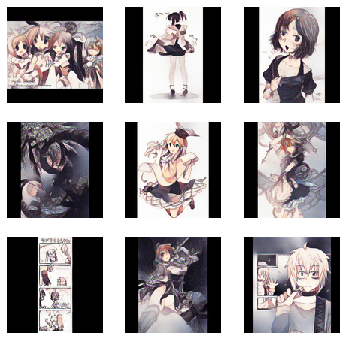

>50, 1/498, d1=0.574, d2=0.769 g=4.346
>50, 51/498, d1=0.633, d2=1.046 g=4.631
>50, 101/498, d1=0.721, d2=0.703 g=4.400
>50, 151/498, d1=0.907, d2=0.802 g=4.034


In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=60, n_batch=8, init_epoch=30)

In [0]:
saveWeights(gan_model, g_model, d_model)

NameError: ignored

In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=90, n_batch=8, init_epoch=60)


In [0]:
saveWeights(gan_model, g_model, d_model)

>100, 498/498, d1=0.598, d2=0.604 g=4.851
Train PNSR: 14.32558687456806
Test PNSR: 14.050822933583186
Train SSIM: 0.6706567415530101
Test SSIM  0.6752247835662566
>Accuracy real: 100%, fake: 40%


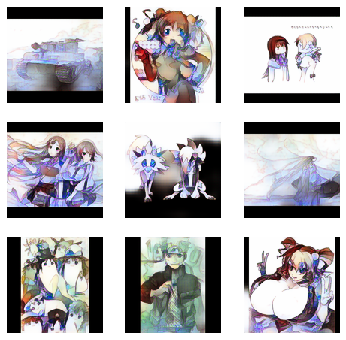

In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=100, n_batch=8, init_epoch=99)
saveWeights(gan_model, g_model, d_model)


>120, 498/498, d1=0.593, d2=0.815 g=4.170
Train PNSR: 11.415818620990585
Test PNSR: 11.989731598624065
Train SSIM: 0.5828139680925503
Test SSIM  0.5419016844911685
>Accuracy real: 100%, fake: 0%


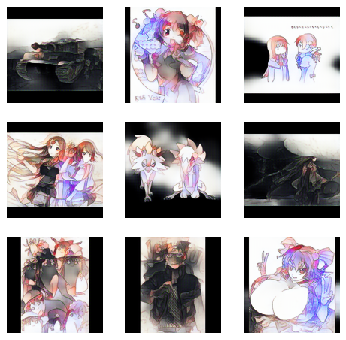

In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=120, n_batch=8, init_epoch=100)
saveWeights(gan_model, g_model, d_model)


>170, 498/498, d1=0.790, d2=0.587 g=5.344
Train PNSR: 12.539188019467455
Test PNSR: 12.433015463589587
Train SSIM: 0.5816573121100308
Test SSIM  0.5450578907908484
>Accuracy real: 0%, fake: 70%


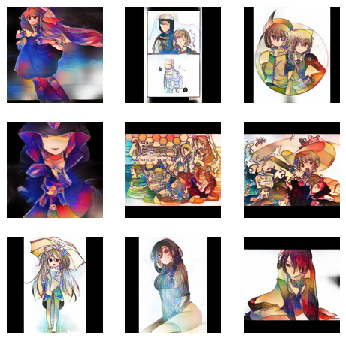

In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=170, n_batch=8, init_epoch= 140)
saveWeights(gan_model, g_model, d_model)


Time for epoch 171 : 0:03:27.899263
>171, 498/498, d1=0.691, d2=1.158 g=5.684
Train PNSR: 11.788697005509224
Test PNSR: 11.99455033386352
Train SSIM: 0.48580980718864925
Test SSIM  0.50749169434285
>Accuracy real: 90%, fake: 20%


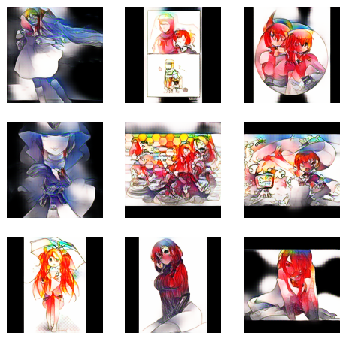

>172, 1/498, d1=0.682, d2=0.431 g=5.547


KeyboardInterrupt: ignored

In [0]:
train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=200, n_batch=8, init_epoch= 170)
saveWeights(gan_model, g_model, d_model)